# 1. Overview
Tujuan dari notebook ini adalah untuk menginterpretasikan model ML yang dibangun dan memberikan insight bisnis dari model. Dengan menganalisis faktor-faktor pendorong utama dibalik prediksi model, kita dapat mengidentifikasi peluang strategis dan merekomendasikan langkah langkah konkret untuk membantu keputusan dalam approval kredit,dll

In [83]:
import shap
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 2. Feature Importance (Random Forest)

In [2]:
model_prediksi_kredit = None
with open("..//model//model_prediksi-kredit.pkl",'rb') as file:
    model_prediksi_kredit = pickle.load(file)

model_prediksi_kredit

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('column_encoder',
                                                  OneHotEncoder(),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'age_bin',
                                                   'credit_bin',
                                                   'duration_bin']),
                                                 ('numeric_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Credit amount',
                                                   'Duration', 'Job'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=10,
                                        min_samples_split=6, n_estimators=354,
                                        random_state=42))])

In [3]:
ohe_features_name = model_prediksi_kredit.named_steps['transformer'].named_transformers_['column_encoder'].get_feature_names_out()
numerical_features_name = model_prediksi_kredit.named_steps['transformer'].named_transformers_['numeric_scaler'].get_feature_names_out()
all_features_name = list(ohe_features_name) + list(numerical_features_name)
feature_importances = model_prediksi_kredit.named_steps['model'].feature_importances_

feature_importances = pd.DataFrame({
    'features':all_features_name,
    'importances':feature_importances
}).sort_values(by='importances',ascending=False)
feature_importances.head()


,features,importances
10,Checking account_Unknown,0.220837
11,Checking account_little,0.122643
39,Credit amount,0.106106
40,Duration,0.101438
38,Age,0.070633


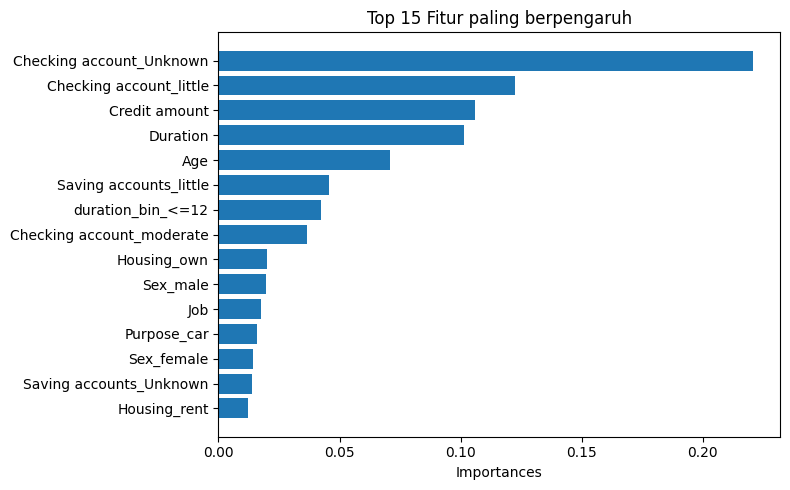

In [4]:
plt.figure(figsize=(8,5))
plt.barh(feature_importances['features'][:15][::-1], feature_importances['importances'][:15][::-1])  # Tampilkan 15 teratas
plt.xlabel('Importances')
plt.title('Top 15 Fitur paling berpengaruh')
plt.tight_layout()
plt.show()

#### Hasil
Dari hasil visualisasi, didapat bahwa:
1. Fitur checking_account_Unknown dan checking_account_little adalah 2 fitur paling menentukan dalam risiko gagal bayar. Artinya, nasabah yang tidak memiliki informasi rekening giro ataupun yang memiliki saldo kecil di rekening giro, sangat rentan gagal bayar
    - Saran bisnis: Nasabah yang termasuk dalam kategori ini wajib untuk verifikasi lebih lanjut atau pertimbangan untuk menolak aplikasi kredit dari nasabah dengan kategori ini
2. Fitur credit amount dan Duration juga termasuk fitur penting. Artinya, semakin besar jumlah pinjaman atau semakin lama durasi pinjaman, maka semakin besar risiko gagal bayar.
    - Saran bisnis : Untuk nasabah jumlah pinjaman besar ataupun durasi pinjaman lama, perlu adanya syarat tambahan seperti jaminan.
3. Fitur Age, Saving accounts_little, dan Purpose_car juga relevan, walau tidak sepenting fitur-fitur diatas
4. Fitur hasil binning seperti duration_bin dan age_bin muncul sebagai penjelas tambahan, yang mengindikasikan segmentasi usia dan durasi turut memperkuat model.

##### Highlight untuk Bisnis:
- Fokus utama tim underwriting harus pada status rekening giro dan jumlah pinjaman saat proses screening awal.
- Segmentasi lebih lanjut bisa dibuat untuk nasabah dengan checking account “Unknown” atau “little” agar mitigasi risiko lebih presisi.

# 3. SHAP Analysis

In [ ]:
preprocessor = model_prediksi_kredit.named_steps['transformer']
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_test_transformed, 'toarray'):
    X_test_transformed = X_test_transformed.toarray()
X_test_np = X_test_transformed.astype(float)  
X_test_df = pd.DataFrame(X_test_np,columns=all_features_name)
rf = model_prediksi_kredit.named_steps['model']
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_np)

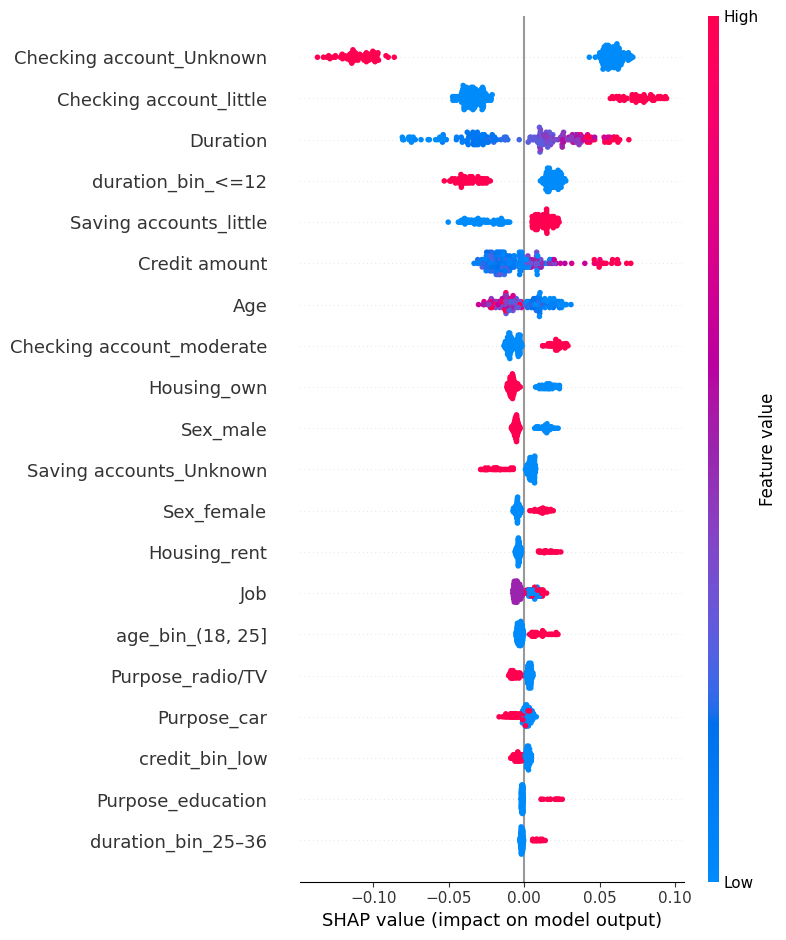

In [ ]:
explainer = shap.Explainer(rf, X_test_df)
shap_values = explainer(X_test_df)
    shap.summary_plot(shap_values.values[:, :, 1], X_test_df)

##### Pada summary plot, kita melihat fitur mana yang rata-rata paling mempengaruhi prediksi default risk.

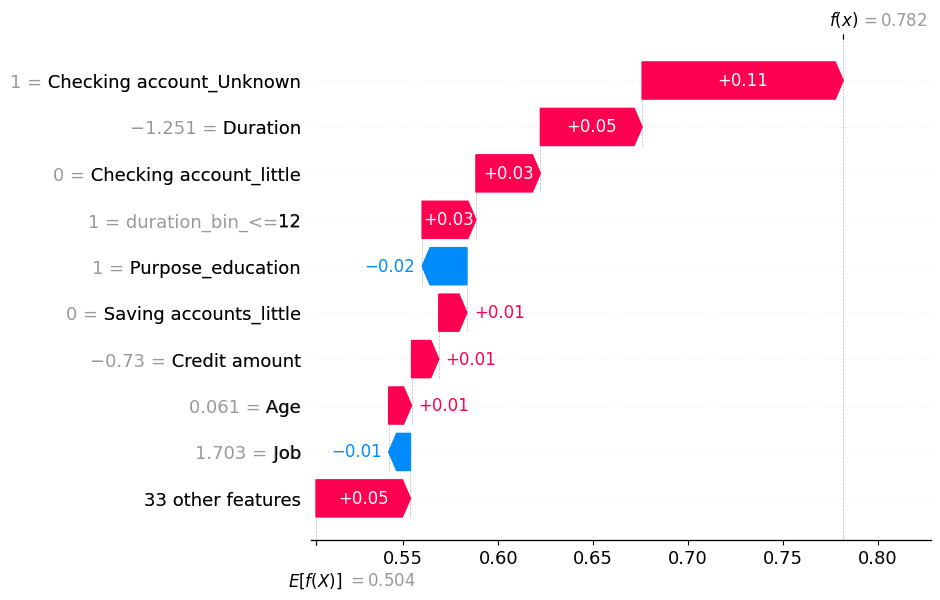

In [ ]:
idx = 56
shap.plots.waterfall(shap_values[idx, :, 0])

##### Pada waterfall plot dimana ini merupakan plot SHAP untuk prediksi user ke-56, f(X) = 0.782. Disini karena treshold di 0.5 -> Model memprediksi nasabah termasuk gagal bayar.
- Dalam hal ini, kenapa model memprediksi demikian bisa dilihat dari fitur yang menaikkan risiko:
    - Checking account_Unknown dimana disini nasabah tidak memiliki informasi rekening giro yang meningkatkan risiko dengan signifikan sebesar 11%. Selaras dengan feature importances dan summary plot SHAP yang menunjukkan Checking account Unknown sebagai fitur yang paling berpengaruh
    - Duration juga menaikkan risiko sebesar 5%, Checking account_little 0 dan durasi pinjaman < 12 yang sama-sama menaikkan risiko 3%
    - Purpose education menurunkan risiko sebesar 2% dimana ini sejalan dengan hasil eda di notebook awalnya yang mana rata rata nasabah dengan tujuan pendidikan memiliki risiko gagal bayar yang lebih rendah dibanding purpose lain.
    - Fitur fitur lain seperti credit amount, Saving account,dll juga menaikkan dan menurunkan risiko walau tidak sebesar fitur fitur diatas

# 4. Segmentasi Risiko Nasabah

In [ ]:
y_test = pd.read_csv("..//data//y_test.csv")
y_pred_proba = model_prediksi_kredit.predict_proba(X_test)[:, 0] 

def risk_segment(prob):
    if prob < 0.4:
        return "Low"
    elif prob < 0.7:
        return "Medium"
    else:
        return "High"

risk_categories = [risk_segment(p) for p in y_pred_proba]

df_risk = X_test.copy()
df_risk['risk_prob'] = y_pred_proba
df_risk['risk_segment'] = risk_categories
df_risk['actual'] = y_test.values 
print(df_risk['risk_segment'].value_counts())

risk_segment
Medium    103
Low        61
High       36
Name: count, dtype: int64


In [107]:
df_risk

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,age_bin,credit_bin,duration_bin,risk_prob,risk_segment,actual,predicted,miss
0,36,male,2,own,rich,moderate,1913,18,business,"(35, 40]",very low,13-24,0.512807,Medium,0,0,Correct
1,34,male,3,own,little,moderate,1860,12,car,"(30, 35]",very low,<=12,0.510683,Medium,0,0,Correct
2,48,male,2,own,little,little,1024,24,radio/TV,"(40, 50]",very low,13-24,0.280108,Low,1,1,Correct
3,31,male,2,own,little,little,3104,18,business,"(30, 35]",low,13-24,0.305480,Low,0,1,False Negative
4,23,male,1,own,quite rich,moderate,2520,27,radio/TV,"(18, 25]",low,25–36,0.491788,Medium,1,1,Correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,53,male,2,free,little,little,7119,48,furniture/equipment,"(50, 60]",mid,37–48,0.205670,Low,1,1,Correct
196,42,male,2,own,Unknown,moderate,2427,18,business,"(40, 50]",low,13-24,0.605595,Medium,0,0,Correct
197,25,male,2,own,little,Unknown,1262,12,radio/TV,"(18, 25]",very low,<=12,0.736427,High,0,0,Correct
198,31,male,2,own,Unknown,little,6350,30,furniture/equipment,"(30, 35]",mid,25–36,0.380685,Low,1,1,Correct


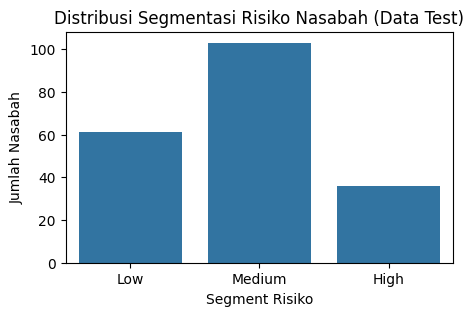

In [101]:
plt.figure(figsize=(5,3))
sns.countplot(x='risk_segment', data=df_risk, order=['Low','Medium','High'])
plt.title('Distribusi Segmentasi Risiko Nasabah (Data Test)')
plt.xlabel('Segment Risiko')
plt.ylabel('Jumlah Nasabah')
plt.show()


In [ ]:
df_risk['predicted'] = (y_pred_proba <= 0.5).astype(int) 

df_risk['miss'] = 'Correct'
df_risk.loc[(df_risk['actual']==0) & (df_risk['predicted']==1), 'miss'] = 'False Negative'
df_risk.loc[(df_risk['actual']==1) & (df_risk['predicted']==0), 'miss'] = 'False Positive'

print(df_risk['miss'].value_counts())

miss
Correct           146
False Negative     42
False Positive     12
Name: count, dtype: int64


In [114]:
df_risk[df_risk['miss']!='Correct']['risk_segment'].value_counts()

risk_segment
Low       28
Medium    22
High       4
Name: count, dtype: int64

In [116]:
df_risk[df_risk['risk_segment']=='High'].describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,age_bin,credit_bin,duration_bin,risk_prob,risk_segment,actual,predicted,miss
count,36.000000,36,36.000000,36,36,36,36.000000,36.000000,36,36,36,36,36.000000,36,36.000000,36.0,36
unique,NaN,2,NaN,3,5,1,NaN,NaN,6,7,2,4,NaN,1,NaN,NaN,2
top,NaN,male,NaN,own,little,Unknown,NaN,NaN,radio/TV,"(40, 50]",very low,<=12,NaN,High,NaN,NaN,Correct
freq,NaN,28,NaN,33,15,36,NaN,NaN,15,10,22,26,NaN,36,NaN,NaN,32
mean,42.194444,NaN,1.833333,NaN,NaN,NaN,1808.138889,14.000000,NaN,NaN,NaN,NaN,0.762890,NaN,0.111111,0.0,NaN
std,12.519287,NaN,0.654654,NaN,NaN,NaN,827.015120,8.876936,NaN,NaN,NaN,NaN,0.036806,NaN,0.318728,0.0,NaN
min,22.000000,NaN,1.000000,NaN,NaN,NaN,250.000000,4.000000,NaN,NaN,NaN,NaN,0.703668,NaN,0.000000,0.0,NaN
25%,33.000000,NaN,1.000000,NaN,NaN,NaN,1280.750000,10.000000,NaN,NaN,NaN,NaN,0.737824,NaN,0.000000,0.0,NaN
50%,41.000000,NaN,2.000000,NaN,NaN,NaN,1545.000000,12.000000,NaN,NaN,NaN,NaN,0.764198,NaN,0.000000,0.0,NaN
75%,49.750000,NaN,2.000000,NaN,NaN,NaN,2282.250000,15.000000,NaN,NaN,NaN,NaN,0.783297,NaN,0.000000,0.0,NaN


#### 5. Insight
- Segmentasi risiko menunjukkan bahwa mayoritas nasabah berada di kategori low dan medium_risk.
- Segmentasi menunjukkan bahwa nasabah High Risk (≥0.7): seringkali tidak punya rekening giro atau memiliki saving account ‘little’, serta cenderung mengambil pinjaman dengan durasi lebih panjang.

Evaluasi salah prediksi (‘miss’) membantu tim underwriting untuk memperbaiki strategi mitigasi—misal, nasabah yang secara historis default tapi diprediksi low risk bisa dijadikan prioritas review manual.”

#### 6. Keterbatasan Model & Next Step

##### Keterbatasan Model & Data
- Dataset yang digunakan relatif kecil (hanya 1000 data), sehingga berisiko overfitting dan hasil model belum tentu generalizable ke seluruh populasi nasabah.
- Tidak tersedia fitur waktu atau histori perilaku pembayaran, sehingga model tidak bisa mendeteksi perubahan perilaku nasabah dari waktu ke waktu.
- Informasi penting seperti penghasilan, histori pembayaran bulanan, dan data eksternal (misal dari credit bureau) tidak tersedia, sehingga model bekerja dengan informasi terbatas.
- Rasio data imbalanced (good:bad sekitar 70:30), sehingga walaupun sudah di-handle dengan undersampling, tetap ada risiko model bias terhadap mayoritas.
- Potensi bias pada kelompok tertentu (misal: usia muda, tabungan rendah) karena tidak dilakukan fairness audit secara spesifik.
- Model ini hanya digunakan sebagai decision support, bukan penentu tunggal, karena masih ada risiko error dan keterbatasan data.

##### Saran Pengembangan ke Depan
- Gunakan dataset yang lebih besar dan lebih bervariasi untuk meningkatkan generalisasi model.
- Tambahkan fitur waktu dan histori perilaku, seperti riwayat pembayaran bulanan, jumlah pengajuan, atau penggunaan kredit dalam periode waktu tertentu.
- Integrasi data eksternal seperti credit bureau dan e-wallet untuk memperkaya fitur.
